In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import cv2
from sklearn.utils import shuffle
from tqdm import tqdm

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
#1. load images

train_folder = "/Users/macbook/Downloads/Projects/Neural Network/seg_train/"
test_folder = "/Users/macbook/Downloads/Projects/Neural Network/seg_test/"

img_height = 80
img_width = 80

def load_images(directory):
    Images = []
    Labels = []
    label = 0
    
    for labels in os.listdir(directory):
        if labels == 'buildings':
            label = 0
        elif labels == 'forest':
            label = 1
        elif labels == 'glacier':
            label = 2
        elif labels == 'mountain':
            label = 3
        elif labels == 'sea':
            label = 4
        elif labels == 'street':
            label = 5
        
        for image_file in os.listdir(directory+labels):
            image = cv2.imread(directory+labels+r'/'+image_file)
            image = cv2.resize(image, (img_height, img_width))
            Images.append(image)
            Labels.append(label)
            
    return shuffle(Images, Labels, random_state=1024)

In [3]:
train_images, train_labels = load_images(train_folder)
test_images, test_labels = load_images(test_folder)

In [4]:
#convert to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [5]:
#2. visualise the data

label_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

def visualize_image(label_names, images, labels):
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i])
        plt.title(label_names[labels[i]])
        plt.axis("off")
    plt.show()
        

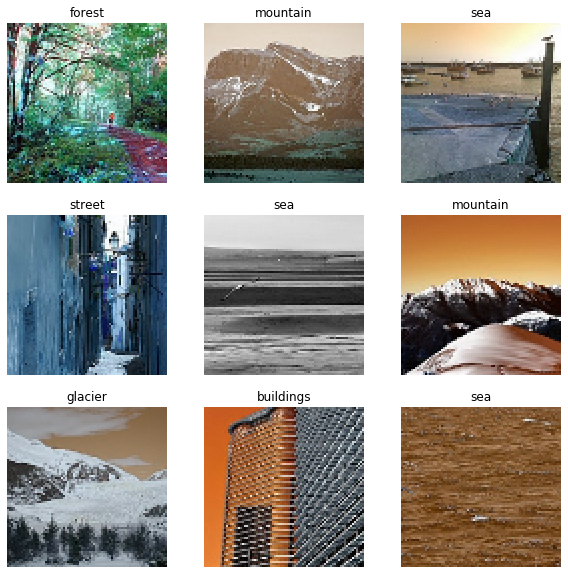

In [6]:
visualize_image(label_names, train_images, train_labels)

In [7]:
#rescale the data

train_images = train_images/255
test_images = test_images/255

In [9]:
#3. Feature Extraction with VGG16 + 1-layer Neural Networks

In [10]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(train_images.shape[1:]), classes=6)

In [12]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 20, 128)       0     

In [15]:
train_features = vgg16.predict(train_images, verbose=1)
test_features = vgg16.predict(test_images, verbose=1)

94/94 [==============================] - 105s 1s/step


In [16]:
print(train_features.shape, test_features.shape)

(14034, 2, 2, 512) (3000, 2, 2, 512)


In [18]:
#flatten extracted features

train_features = np.reshape(train_features, (14034, 2*2*512))
test_features = np.reshape(test_features, (3000, 2*2*512))

In [43]:
#define the model

cnn = Sequential()

cnn.add(Dense(128, activation='relu', input_shape=(train_features.shape[1],)))
cnn.add(Dropout(0.3))
cnn.add(Dense(64, activation='relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(6, activation='softmax'))

#compile the model

cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 6)                 390       
Total params: 270,918
Trainable params: 270,918
Non-trainable params: 0
_________________________________________________________________


In [44]:
#fit the model

epochs = 20
batch_size = 256
es = EarlyStopping(monitor='val_loss', patience=5)

history = cnn.fit(train_features, train_labels, validation_split=0.2, 
        epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[es])

#evaluate the model
train_loss, train_acc = cnn.evaluate(train_features, train_labels)
#train_loss, train_acc = cnn.evaluate(val_features, y_val)
test_loss, test_acc = cnn.evaluate(test_features, test_labels)

Epoch 1/20
44/44 - 0s - loss: 0.9338 - accuracy: 0.6422 - val_loss: 0.5441 - val_accuracy: 0.8023
Epoch 2/20
44/44 - 0s - loss: 0.5682 - accuracy: 0.7987 - val_loss: 0.4775 - val_accuracy: 0.8237
Epoch 3/20
44/44 - 1s - loss: 0.4948 - accuracy: 0.8258 - val_loss: 0.4559 - val_accuracy: 0.8326
Epoch 4/20
44/44 - 0s - loss: 0.4493 - accuracy: 0.8420 - val_loss: 0.4358 - val_accuracy: 0.8372
Epoch 5/20
44/44 - 0s - loss: 0.4176 - accuracy: 0.8537 - val_loss: 0.4373 - val_accuracy: 0.8436
Epoch 6/20
44/44 - 0s - loss: 0.3888 - accuracy: 0.8640 - val_loss: 0.4162 - val_accuracy: 0.8482
Epoch 7/20
44/44 - 0s - loss: 0.3649 - accuracy: 0.8710 - val_loss: 0.4186 - val_accuracy: 0.8440
Epoch 8/20
44/44 - 0s - loss: 0.3395 - accuracy: 0.8774 - val_loss: 0.4134 - val_accuracy: 0.8518
Epoch 9/20
44/44 - 0s - loss: 0.3247 - accuracy: 0.8836 - val_loss: 0.4126 - val_accuracy: 0.8514
Epoch 10/20
44/44 - 0s - loss: 0.3051 - accuracy: 0.8904 - val_loss: 0.4092 - val_accuracy: 0.8575
Epoch 11/20
44/44 -

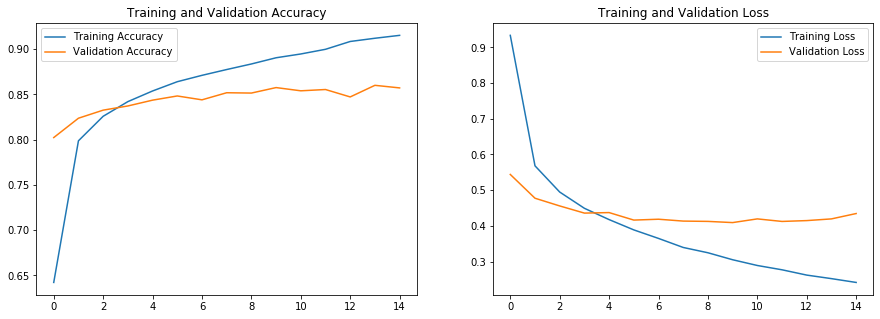

In [45]:
# learning curve
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('Training and Validation Loss')

plt.show()